# Animal Disease Prediction EDA + XGBoost

In this notebook, we aim to predict the occurrence of animal diseases using XGBoost for its performance and usefulness for structured data. 

### Objectives:
1. Perform exploratory data analysis (EDA) to uncover patterns and relationships in the dataset.
2. Preprocess the data to make it suitable for machine learning.
3. Train and evaluate an XGBoost model to predict disease occurrence.
4. Interpret model results and assess its performance.

***

### Importing Libraries

We import the necessary libraries required for data manipulation, visualization, machine learning modeling, and evaluation.

- **pandas**: Used for data manipulation and analysis.
- **numpy**: Provides support for numerical computations.
- **seaborn** and **matplotlib**: Libraries for data visualization to understand patterns and distributions.
- **scikit-learn**: A machine learning library for preprocessing, feature selection, model evaluation, and metrics.
- **xgboost**: A powerful gradient boosting algorithm used for classification and regression tasks.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier



In [2]:
df = pd.read_csv('cleaned_animal_disease_prediction.csv')
df.head()

,Animal_Type,Breed,Age,Gender,Weight,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Duration,...,Diarrhea,Coughing,Labored_Breathing,Lameness,Skin_Lesions,Nasal_Discharge,Eye_Discharge,Body_Temperature,Heart_Rate,Disease_Prediction
0,Dog,Labrador,4,Male,25.0,Fever,Lethargy,Appetite Loss,Vomiting,3 days,...,No,No,No,No,No,No,No,39.5°C,120,Parvovirus
1,Cat,Siamese,2,Female,4.5,Coughing,Sneezing,Eye Discharge,Nasal Discharge,1 week,...,No,Yes,No,No,No,Yes,Yes,38.9°C,150,Upper Respiratory Infection
2,Cow,Holstein,3,Female,600.0,Fever,Nasal Discharge,Labored Breathing,Coughing,5 days,...,No,Yes,Yes,No,No,Yes,No,40.1°C,90,Foot and Mouth Disease
3,Dog,Beagle,1,Male,10.0,Diarrhea,Vomiting,Lethargy,Appetite Loss,2 days,...,Yes,No,No,No,No,No,No,39.2°C,130,Gastroenteritis
4,Cat,Persian,5,Male,3.8,Lethargy,Appetite Loss,Skin Lesions,No,2 weeks,...,No,No,No,No,Yes,No,No,38.7°C,160,Fungal Infection


## Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is a critical step to:

- Understand the dataset’s structure, including the types and ranges of values.
- Identify potential issues such as missing data or outliers.
- Derive insights that inform feature selection and preprocessing.

Key steps:
- Display dataset information using `df.info()` to identify column types and null values.
- Explore unique values in key columns to understand categorical and numerical distributions.
- Visualize data distributions and correlations using plots to detect patterns.


In [3]:
# Data shape and type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Animal_Type         431 non-null    object 
 1   Breed               431 non-null    object 
 2   Age                 431 non-null    int64  
 3   Gender              431 non-null    object 
 4   Weight              431 non-null    float64
 5   Symptom_1           431 non-null    object 
 6   Symptom_2           431 non-null    object 
 7   Symptom_3           431 non-null    object 
 8   Symptom_4           431 non-null    object 
 9   Duration            431 non-null    object 
 10  Appetite_Loss       431 non-null    object 
 11  Vomiting            431 non-null    object 
 12  Diarrhea            431 non-null    object 
 13  Coughing            431 non-null    object 
 14  Labored_Breathing   431 non-null    object 
 15  Lameness            431 non-null    object 
 16  Skin_Les

In [4]:
contingency_table = pd.crosstab(df['Animal_Type'], df['Symptom_1'])
contingency_table

Symptom_1,Appetite Loss,Coughing,Decreased Milk Yield,Diarrhea,Eye Discharge,Fever,Labored Breathing,Lameness,Lethargy,Loss of Appetite,Nasal Discharge,Skin Lesions,Sneezing,Swollen Joints,Vomiting,Weight Loss
Animal_Type,,,,,,,,,,,,,,,,
Cat,4,21,0,0,7,0,0,0,9,0,16,1,3,0,11,0
Cow,3,40,1,5,0,8,1,0,5,2,1,0,0,0,0,2
Dog,0,14,0,2,0,3,2,4,33,0,0,0,1,0,16,0
Goat,0,0,0,4,0,2,0,0,0,0,1,0,0,0,32,0
Horse,1,5,0,0,0,2,0,50,2,0,1,0,0,3,0,2
Pig,0,33,0,0,0,1,0,0,0,0,0,0,1,0,3,0
Rabbit,0,0,0,1,0,0,0,0,1,0,4,0,28,0,0,0
Sheep,0,28,0,0,0,0,0,1,2,0,0,0,0,5,0,3


In [5]:
# Chi-square contigency of dataset
chi2, p_value, dof, expected = chi2_contingency(contingency_table.values)

print("Chi-square statistic:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Chi-square statistic: 1074.8845297668736
p-value: 1.5846329638707856e-160
Degrees of freedom: 105
Expected frequencies:
 [[ 1.33642691 23.55452436  0.16705336  2.00464037  1.16937355  2.67285383
   0.50116009  9.18793503  8.68677494  0.33410673  3.84222738  0.16705336
   5.51276102  1.33642691 10.35730858  1.16937355]
 [ 1.26218097 22.24593968  0.15777262  1.89327146  1.10440835  2.52436195
   0.47331787  8.6774942   8.20417633  0.31554524  3.6287703   0.15777262
   5.20649652  1.26218097  9.78190255  1.10440835]
 [ 1.39211137 24.53596288  0.17401392  2.08816705  1.21809745  2.78422274
   0.52204176  9.57076566  9.0487239   0.34802784  4.00232019  0.17401392
   5.7424594   1.39211137 10.78886311  1.21809745]
 [ 0.72389791 12.7587007   0.09048724  1.08584687  0.63341067  1.44779582
   0.27146172  4.97679814  4.70533643  0.18097448  2.0812065   0.09048724
   2.98607889  0.72389791  5.61020882  0.63341067]
 [ 1.225058   21.59164733  0.15313225  1.83758701  1.07192575  2.45011601
   0.4593

In [6]:
# Animal distribution
animal_dist = df['Animal_Type'].value_counts(normalize=True) * 100
print("Animal Distribution (%):")
print(animal_dist)

# Animal Type vs Gender
gender_dist = pd.crosstab(df['Animal_Type'], df['Gender'], normalize='index') * 100
print("\nGender Distribution by Animal Type (%):")
print(gender_dist)

Animal Distribution (%):
Animal_Type
Dog       17.401392
Cat       16.705336
Cow       15.777262
Horse     15.313225
Sheep      9.048724
Goat       9.048724
Pig        8.816705
Rabbit     7.888631
Name: proportion, dtype: float64

Gender Distribution by Animal Type (%):
Gender          Female       Male
Animal_Type                      
Cat          44.444444  55.555556
Cow          54.411765  45.588235
Dog          46.666667  53.333333
Goat         64.102564  35.897436
Horse        45.454545  54.545455
Pig          47.368421  52.631579
Rabbit       47.058824  52.941176
Sheep        33.333333  66.666667


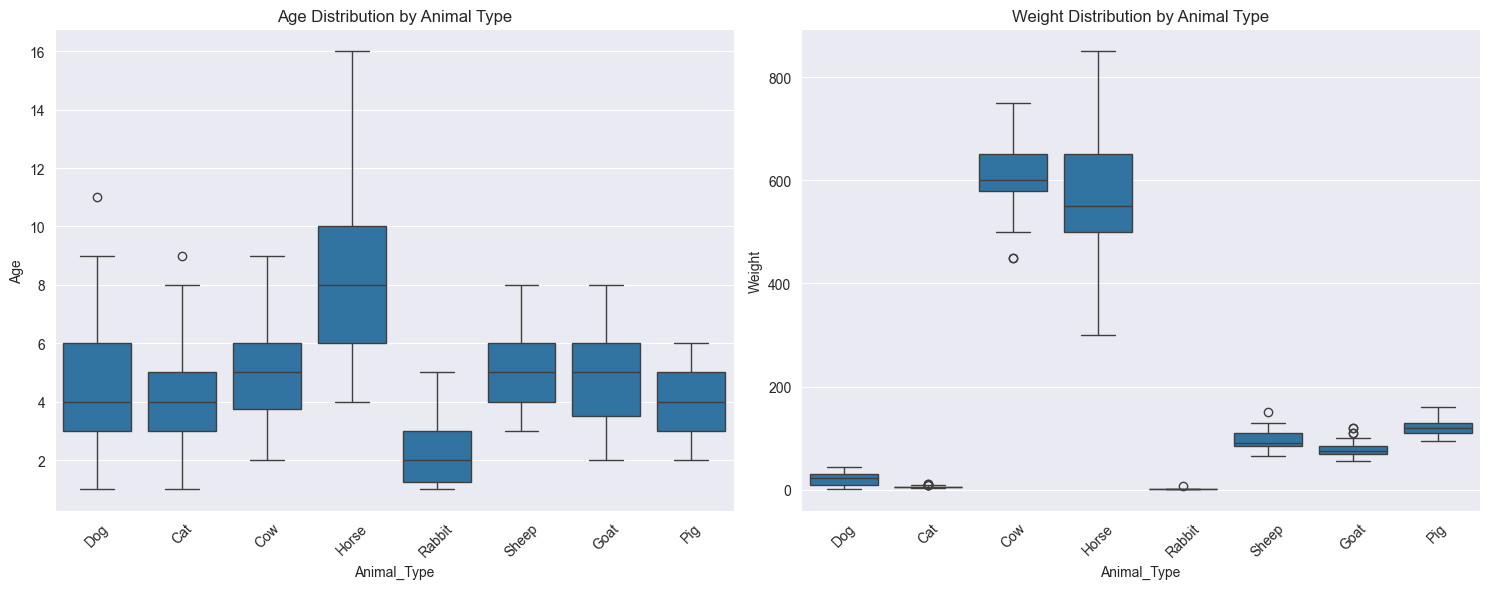

In [7]:
# Age and weight distributions by animal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(x='Animal_Type', y='Age', data=df, ax=ax1)
ax1.set_title('Age Distribution by Animal Type')
ax1.tick_params(axis='x', rotation=45)

sns.boxplot(x='Animal_Type', y='Weight', data=df, ax=ax2)
ax2.set_title('Weight Distribution by Animal Type')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

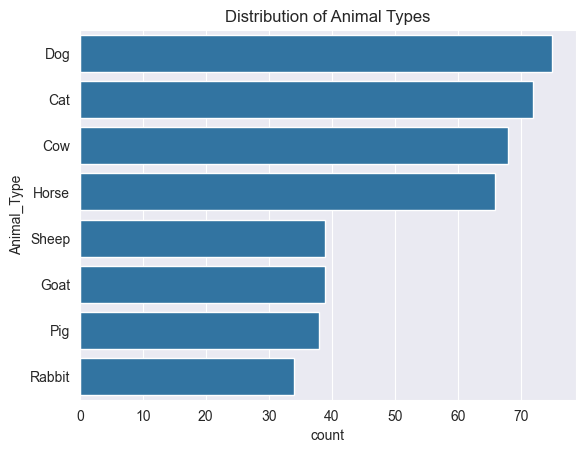

In [8]:
# Distribution of animals
sns.countplot(data=df, y='Animal_Type', order=df['Animal_Type'].value_counts().index)
plt.title('Distribution of Animal Types')
plt.show()

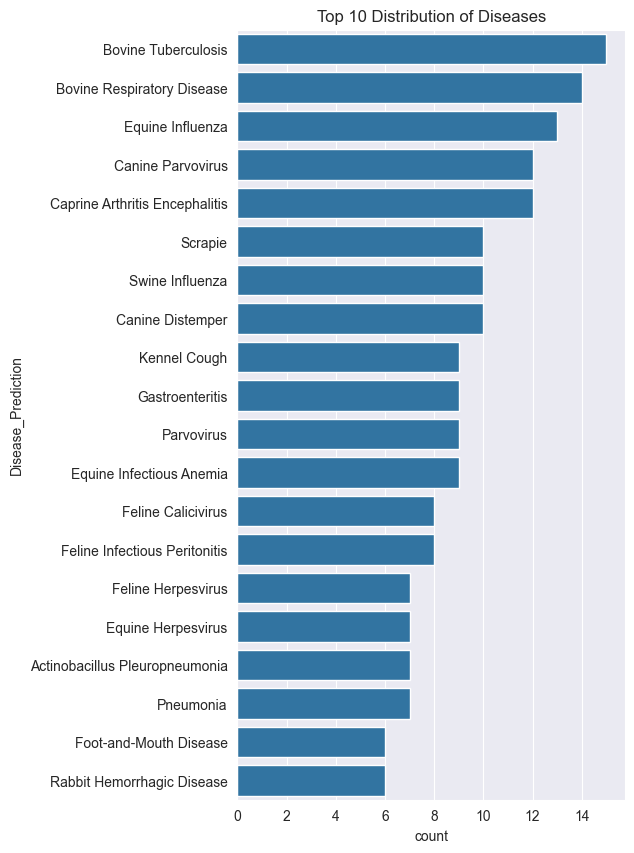

In [9]:
# Top 10 diseases
plt.figure(figsize=(5, 10))
sns.countplot(data=df, y='Disease_Prediction', order=df['Disease_Prediction'].value_counts().index[:20])
plt.title('Top 10 Distribution of Diseases')
plt.show()

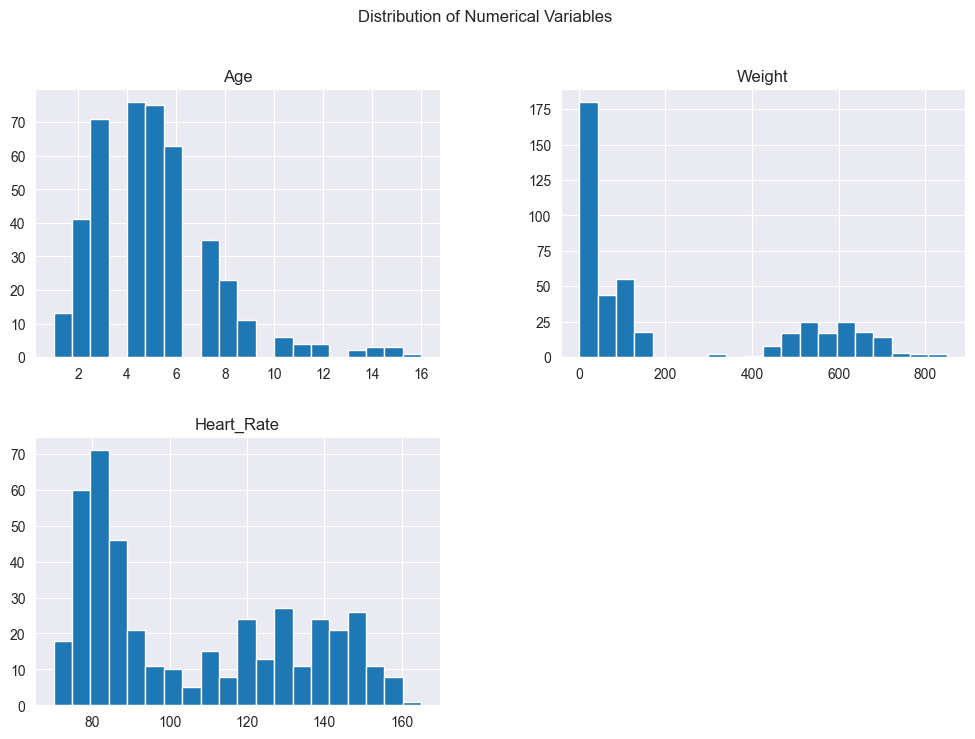

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of numerical columns
df[['Age', 'Weight', 'Heart_Rate', 'Body_Temperature']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution of Numerical Variables')
plt.show()

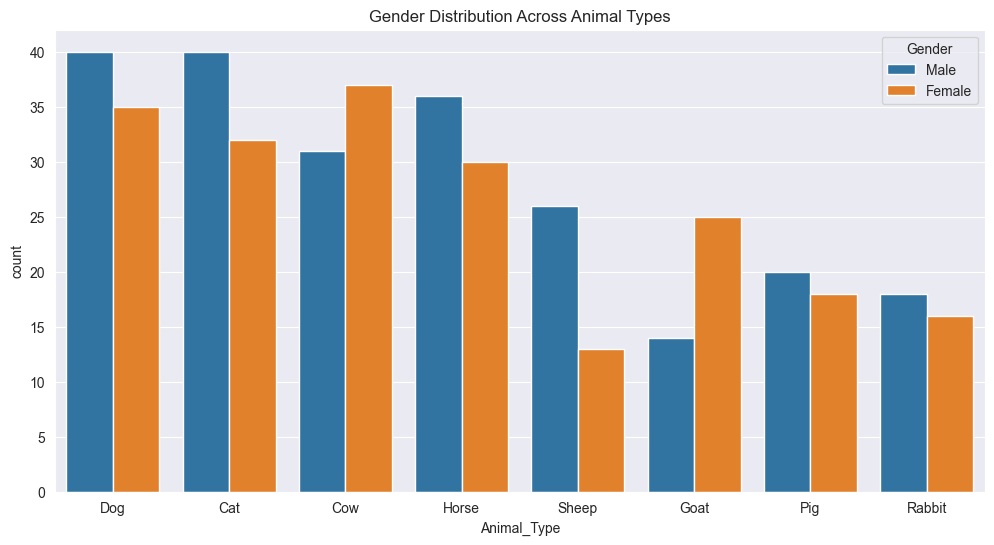

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Animal_Type', hue='Gender', order=df['Animal_Type'].value_counts().index)
plt.title('Gender Distribution Across Animal Types')
plt.show()

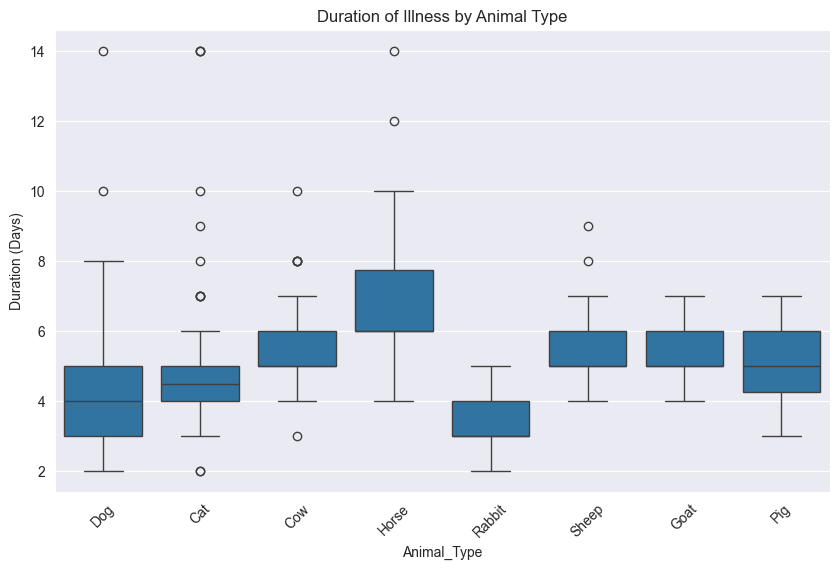

In [12]:
# Convert duration to numeric
df['Duration_Num'] = df['Duration'].str.extract('(\d+)').astype(float)
df.loc[df['Duration'].str.contains('week'), 'Duration_Num'] *= 7

plt.figure(figsize=(10, 6))
sns.boxplot(x='Animal_Type', y='Duration_Num', data=df)
plt.title('Duration of Illness by Animal Type')
plt.ylabel('Duration (Days)')
plt.xticks(rotation=45)
plt.show()

## Data Preprocessing and Feature Engineering

In this section, we prepare the dataset for modeling:

- **Feature Scaling**: Use `StandardScaler` to normalize numeric features, ensuring uniformity for gradient-based models.
- **Feature Selection**: Use `SelectKBest` to retain the most relevant features for prediction, based on statistical tests like ANOVA.
- **Label Encoding**: Transform categorical variables into numeric representations using `LabelEncoder`.

These steps enhance model performance and prevent biases caused by differences in feature scales.


In [13]:
# Compute class frequencies
target_col = 'Disease_Prediction'
value_counts = df[target_col].value_counts(normalize=True)

# Group rare classes
rare_classes = value_counts[value_counts < 0.02].index

# Replace rare classes with 'Other'
df[target_col] = df[target_col].replace(rare_classes, 'Other')

In [14]:
# Binary flags for symptoms
symptom_cols = ['Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing', 
                'Labored_Breathing', 'Lameness', 'Skin_Lesions', 
                'Nasal_Discharge', 'Eye_Discharge']
for col in symptom_cols:
    df[col] = (df[col] == 'Yes').astype(int)

# Temperature conversion
df['Body_Temperature'] = df['Body_Temperature'].astype(str).str.replace('°C', '', regex=False).astype(float)


# Duration conversion
df['Duration_Num'] = df['Duration'].str.extract('(\d+)').astype(float)
df.loc[df['Duration'].str.contains('week'), 'Duration_Num'] *= 7

# Age groups
df['Age_Group'] = pd.cut(df['Age'], 
                        bins=[0, 1, 3, 5, 10, float('inf')],
                        labels=['Infant', 'Young', 'Adult', 'Middle_Aged', 'Senior'])

In [15]:
# Weight categories
def categorize_weight(row):
    if row['Animal_Type'] == 'Dog':
        bins = [0, 10, 25, 40, float('inf')]
        labels = ['Small', 'Medium', 'Large', 'Giant']
    elif row['Animal_Type'] == 'Cat':
        bins = [0, 4, 6, 8, float('inf')]
        labels = ['Small', 'Medium', 'Large', 'Giant']
    else:
        return 'NA'
    return pd.cut([row['Weight']], bins=bins, labels=labels)[0]

df['Weight_Category'] = df.apply(categorize_weight, axis=1)

In [16]:
# Train-test split
X = df.drop(columns=[target_col])
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [17]:
# Feature scaling
scaler = StandardScaler()
num_features = ['Age', 'Weight', 'Body_Temperature', 'Duration_Num']
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [18]:
# Categorical features
cat_features = ['Animal_Type', 'Breed', 'Gender', 'Age_Group', 'Weight_Category']
encoders = {}

for feature in cat_features:
    X_train[feature] = X_train[feature].astype(str)
    X_test[feature] = X_test[feature].astype(str)
    all_unique_values = pd.concat([X_train[feature], X_test[feature]]).unique()
    
    enc = LabelEncoder().fit(all_unique_values)
    encoders[feature] = enc
    
    X_train[feature] = enc.transform(X_train[feature])
    X_test[feature] = X_test[feature].apply(
        lambda x: enc.transform([x])[0] if x in enc.classes_ else -1
    )

# One-hot encode
objs_train = X_train.select_dtypes(['object']).columns
X_train = pd.get_dummies(X_train, columns=objs_train)
X_test = pd.get_dummies(X_test, columns=objs_train)

# Align columns
X_train, X_test = X_train.align(X_test, axis=1, join='left', fill_value=0)


In [19]:
# Encode y_train and y_test
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

# Store class weights
weights_dict = dict(zip(np.unique(y_train_encoded), class_weights))

## Model Training and Evaluation

This section focuses on building and evaluating a predictive model using the XGBoost classifier.

- **Model Selection**: XGBoost is chosen for its efficiency and performance on structured data.
- **Hyperparameter Tuning**: Use `RandomizedSearchCV` to optimize hyperparameters like learning rate, max depth, and number of estimators.
- **Evaluation Metrics**:
  - **Accuracy**: Overall correctness of the model.
  - **F1-Score**: Balances precision and recall, particularly useful for imbalanced datasets.
  - **Confusion Matrix**: Analyzes prediction errors.

The goal is to ensure the model generalizes well to unseen data while maintaining high accuracy and efficiency.



In [20]:
# Remove constant features
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X_train)

# Get mask of non-constant features
non_constant_features = constant_filter.get_support()

# Filter train and test datasets
X_train = X_train.loc[:, non_constant_features]
X_test = X_test.loc[:, non_constant_features]

print(f"Removed {~non_constant_features.sum()} constant features.")


Removed -83 constant features.


In [21]:
# Reduce dimensions
selector = SelectKBest(f_classif, k=20)
X_train_fs = selector.fit_transform(X_train, y_train_encoded)
X_test_fs = selector.transform(X_test)


In [22]:
# Define scoring
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Base estimators
rf_base = RandomForestClassifier(
    random_state=42
)

xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Param grids
rf_param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}
xgb_param_dist = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Random Search for RF and XGB
rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_dist,
    n_iter=8,
    scoring=f1_macro_scorer,
    cv=3,
    n_jobs=-1,
    random_state=42
)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=8,
    scoring=f1_macro_scorer,
    cv=3,
    n_jobs=-1,
    random_state=42
)

# Fit
rf_random_search.fit(X_train_fs, y_train_encoded)
xgb_random_search.fit(X_train_fs, y_train_encoded)

print("Best RF params:", rf_random_search.best_params_)
print("Best XGB params:", xgb_random_search.best_params_)


C:\Users\Roy\PycharmProjects\livestock-disease-management\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:08:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best RF params: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': None, 'class_weight': 'balanced'}
Best XGB params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [23]:
# Get best estimators
rf_best = rf_random_search.best_estimator_
xgb_best = xgb_random_search.best_estimator_

# Evaluate models
for model_name, model in [("Random Forest", rf_best), ("XGBoost", xgb_best)]:
    y_pred = model.predict(X_test_fs)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    
    test_classes = np.unique(y_test_encoded)
    target_names = le.inverse_transform(test_classes)
    
    # Classification report
    report = classification_report(
        y_test_encoded,
        y_pred,
        labels=test_classes,
        target_names=target_names,
        zero_division=1
    )
    
    print(f"=== {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")


=== Random Forest ===
Accuracy: 0.7356
=== XGBoost ===
Accuracy: 0.7241


In [24]:
# Generate classification report
report_dict = classification_report(
    y_test_encoded,
    y_pred,
    labels=test_classes,
    target_names=target_names,
    zero_division=1,
    output_dict=True
)

# Visualize report 
categories = list(report_dict.keys())[:-3]
precision = [report_dict[category]['precision'] for category in categories]
recall = [report_dict[category]['recall'] for category in categories]
f1_score = [report_dict[category]['f1-score'] for category in categories]

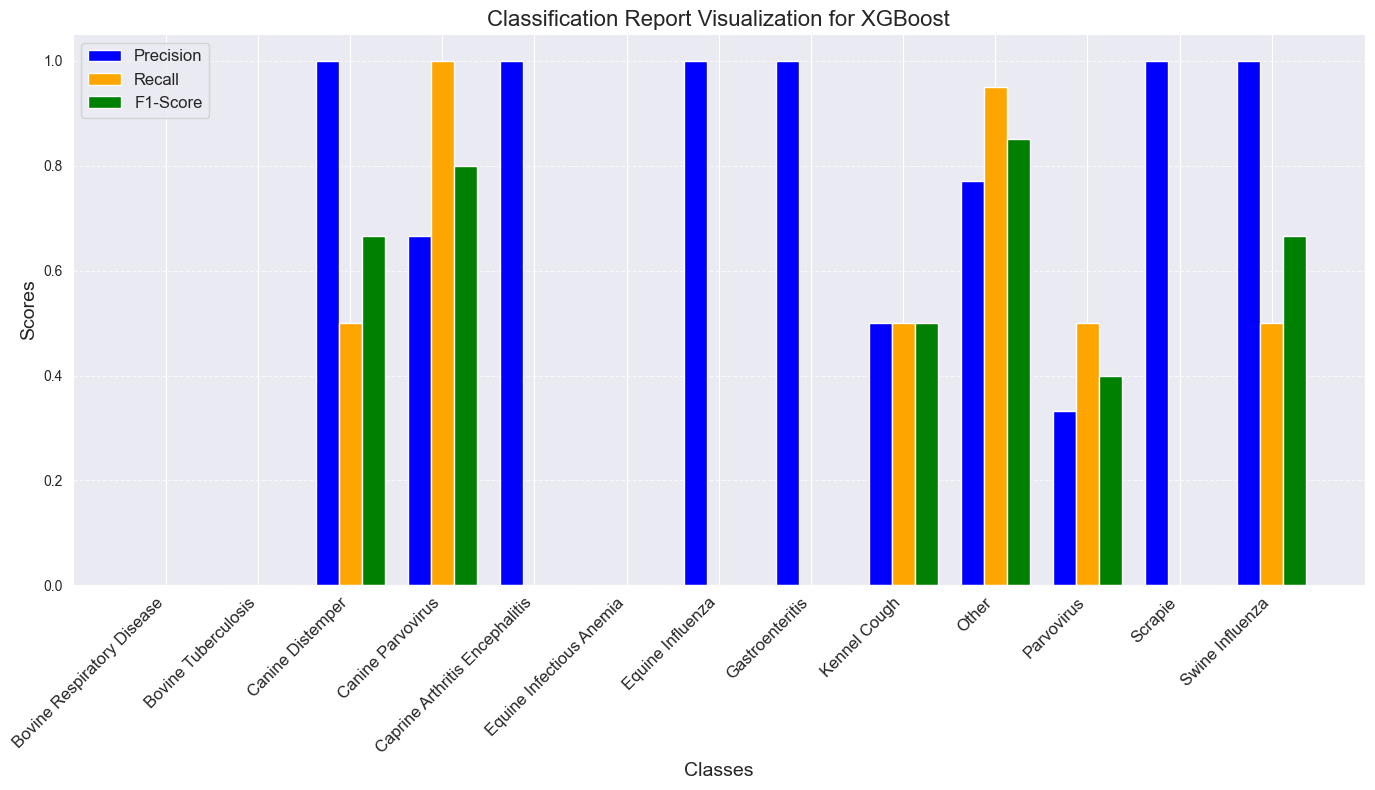

In [27]:
# Plot categories
x = np.arange(len(categories)) 
bar_width = 0.25

# Plot the bars
fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(x - bar_width, precision, bar_width, label='Precision', color='blue')
ax.bar(x, recall, bar_width, label='Recall', color='orange')
ax.bar(x + bar_width, f1_score, bar_width, label='F1-Score', color='green')

# Label the plot
ax.set_xlabel('Classes', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title(f'Classification Report Visualization for {model_name}', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


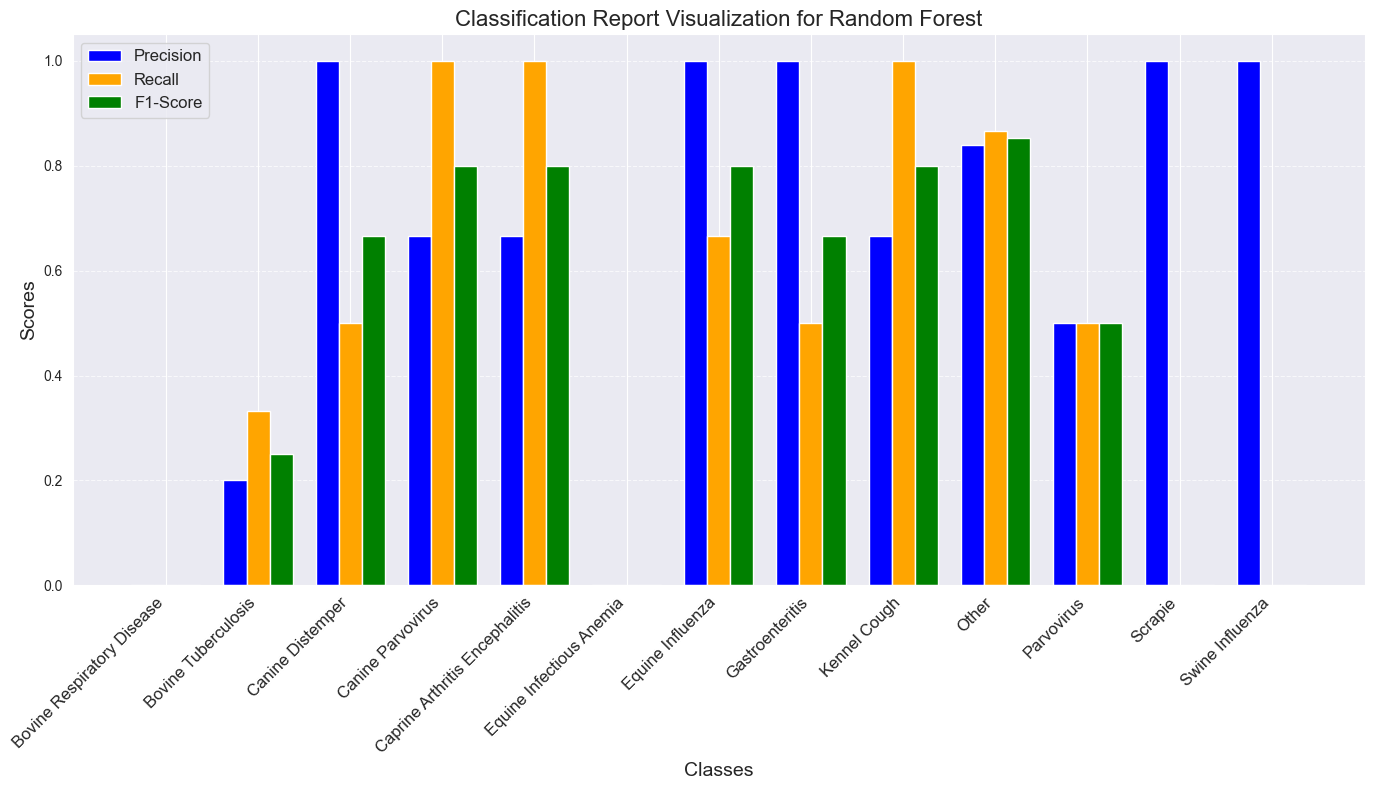

In [28]:
# Generate classification report for Random Forest
rf_pred = rf_best.predict(X_test_fs)
rf_report_dict = classification_report(
    y_test_encoded,
    rf_pred,
    labels=test_classes,
    target_names=target_names,
    zero_division=1,
    output_dict=True
)

# Extract metrics for Random Forest
rf_categories = list(rf_report_dict.keys())[:-3]  # Exclude avg metrics
rf_precision = [rf_report_dict[category]['precision'] for category in rf_categories]
rf_recall = [rf_report_dict[category]['recall'] for category in rf_categories]
rf_f1_score = [rf_report_dict[category]['f1-score'] for category in rf_categories]

# Plot categories for Random Forest
x = np.arange(len(rf_categories))
bar_width = 0.25

# Plot the bars
fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(x - bar_width, rf_precision, bar_width, label='Precision', color='blue')
ax.bar(x, rf_recall, bar_width, label='Recall', color='orange')
ax.bar(x + bar_width, rf_f1_score, bar_width, label='F1-Score', color='green')

# Label the plot
ax.set_xlabel('Classes', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Classification Report Visualization for Random Forest', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(rf_categories, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [29]:
model_filename = 'model/animal_disease_rf_model.joblib'
joblib.dump(rf_best, model_filename)
print(f"Random Forest model saved to {model_filename}")

Random Forest model saved to model/animal_disease_rf_model.joblib


## Conclusion and Next Steps

In this notebook, we explored the Animal Disease dataset, processed the data, trained an XGBoost model, and evaluated its performance. 

**Next Steps:**
1. Perform hyperparameter tuning to further optimize the model.
2. Implement feature importance analysis to identify key predictors.

This workflow demonstrates a complete pipeline for machine learning in predictive analytics. By iterating on these steps, we can achieve robust and actionable insights from the data.
